In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt

In [2]:
# Define a Classif10 neural network
class Classif10(torch.nn.Module):
    def __init__(self, number_of_conv_kernels1,
                 number_of_conv_kernels2,
                 number_of_conv_kernels3,
                 hidden_layer_size,
                 dropout_proportion):
        super(Classif10, self).__init__()
        self.number_of_conv_kernels1 = number_of_conv_kernels1
        self.number_of_conv_kernels2 = number_of_conv_kernels2
        self.number_of_conv_kernels3 = number_of_conv_kernels3
        self.hidden_layer_size = hidden_layer_size

        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=self.number_of_conv_kernels1,
                                     kernel_size=(3, 3), stride=1, padding='same')
        self.conv2 = torch.nn.Conv2d(in_channels=self.number_of_conv_kernels1, out_channels=self.number_of_conv_kernels2,
                                     kernel_size=(3, 3), stride=1, padding='same')
        self.conv3 = torch.nn.Conv2d(in_channels=self.number_of_conv_kernels2, out_channels=self.number_of_conv_kernels3,
                                     kernel_size=(3, 3), stride=1, padding='same')
        self.dropout2d = torch.nn.Dropout2d(p=dropout_proportion)
        self.maxpool2d = torch.nn.MaxPool2d(kernel_size=(2, 2))
        self.batchnorm2d = torch.nn.BatchNorm2d(num_features=self.number_of_conv_kernels2)
        self.linear1 = torch.nn.Linear(in_features=self.number_of_conv_kernels3 * 3 * 3, out_features=self.hidden_layer_size)
        self.linear2 = torch.nn.Linear(in_features=self.hidden_layer_size, out_features=10)
        self.dropout1d = torch.nn.Dropout1d(p=dropout_proportion)

    def forward(self, input_tsr):  # input_tsr.shape = (N, 1, 28, 28)
        act1 = torch.nn.functional.relu(self.conv1(input_tsr))  # (N, C1, 28, 28)
        act2 = self.maxpool2d(act1)  # (N, C1, 14, 14)
        act3 = self.dropout2d(act2)  # (N, C1, 14, 14)
        act4 = torch.nn.functional.relu(self.conv2(act3))  # (N, C2, 14, 14)
        act5 = self.maxpool2d(act4)  # (N, C2, 7, 7)
        act6 = self.batchnorm2d(act5)  # (N, C2, 7, 7)
        act7 = torch.nn.functional.relu(self.conv3(act6))  # (N, C3, 7, 7)
        act8 = self.maxpool2d(act7)  # (N, C3, 3, 3)
        act9 = act8.view(-1, self.number_of_conv_kernels3 * 3 * 3)  # (N, C3 * 3 * 3)
        act10 = torch.nn.functional.relu(self.linear1(act9))  # (N, H)
        act11 = self.dropout1d(act10)  # (N, H)
        act12 = self.linear2(act11)  # (N, 10)
        return act12

In [3]:
# Utility function
def numberOfCorrectPredictions(predictions_tsr, target_class_tsr):
    return sum(torch.argmax(predictions_tsr, dim=1) == target_class_tsr).item()

In [5]:
# Create dataloaders for the mnist dataset
transform = torchvision.transforms.ToTensor()
mnist_dataset = torchvision.datasets.MNIST("./", train=True, download=True, transform=transform)
train_dataset, validation_dataset = torch.utils.data.random_split(mnist_dataset, [48000, 12000])
batch_size = 16
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

In [6]:
# Create the neural network
neural_net = Classif10(16, 32, 64, 256, 0.1)

# Optimization parameters
learning_rate = 0.001
weight_decay = 0.0000001
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(neural_net.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [7]:
# Record statistics
epochs = []
train_losses = []
validation_losses = []
accuracies = []
number_of_epochs = 10
highest_validation_accuracy = 0.0
champion_neural_net = None

In [8]:
    for epoch in range(1, number_of_epochs + 1):
        print(f"Epoch {epoch}")
        # Set the neural network to training mode
        neural_net.train()
        running_loss = 0.0
        number_of_batches = 0
        for input_tsr, target_class_tsr in train_dataloader:
            # Set the parameter gradients to zero before every batch
            neural_net.zero_grad()
            # Pass the input tensor through the neural network
            output_tsr = neural_net(input_tsr)
            # Compute the loss, i.e., the error function we want to minimize
            loss = criterion(output_tsr, target_class_tsr)
            # Retropropagate the loss function, to compute the gradient of the loss function with
            # respect to every trainable parameter in the neural network
            loss.backward()
            # Perturb every trainable parameter by a small quantity, in the direction of the steepest loss descent
            optimizer.step()

            running_loss += loss.item()
            number_of_batches += 1
            if number_of_batches % 100 == 1:
                print(".", flush=True, end='')
        average_training_loss = running_loss / number_of_batches
        # Evaluate with the validation dataset
        # Set the neural network to evaluation (inference) mode
        neural_net.eval()
        validation_running_loss = 0.0
        number_of_batches = 0
        number_of_correct_predictions = 0
        number_of_predictions = 0
        for validation_input_tsr, validation_target_output_tsr in validation_dataloader:
            # Pass the input tensor through the neural network
            validation_output_tsr = neural_net(validation_input_tsr)
            # Compute the validation loss
            validation_loss = criterion(validation_output_tsr, validation_target_output_tsr)
            validation_running_loss += validation_loss.item()
            number_of_correct_predictions += numberOfCorrectPredictions(validation_output_tsr,
                                                                        validation_target_output_tsr)
            number_of_predictions += validation_input_tsr.shape[0]
            number_of_batches += 1
        average_validation_loss = validation_running_loss / number_of_batches
        accuracy = number_of_correct_predictions / number_of_predictions
        print(
            f"average_training_loss = {average_training_loss}; average_validation_loss = {average_validation_loss}; accuracy = {accuracy}")
        epochs.append(epoch)
        train_losses.append(average_training_loss)
        validation_losses.append(average_validation_loss)
        accuracies.append(accuracy)
        if accuracy > highest_validation_accuracy:
            highest_validation_accuracy = accuracy
            champion_neural_net = neural_net

Epoch 1
..............................average_training_loss = 0.35202513142786723; average_validation_loss = 0.0669920722960572; accuracy = 0.9799166666666667
Epoch 2
..............................average_training_loss = 0.2795612095718085; average_validation_loss = 0.05711458034378787; accuracy = 0.9833333333333333
Epoch 3
..............................average_training_loss = 0.2756962874752603; average_validation_loss = 0.04787863304629961; accuracy = 0.9869166666666667
Epoch 4
..............................average_training_loss = 0.26386823848717467; average_validation_loss = 0.04189422611980141; accuracy = 0.9886666666666667
Epoch 5
..............................average_training_loss = 0.25346335188493696; average_validation_loss = 0.03805039695290361; accuracy = 0.99
Epoch 6
..............................average_training_loss = 0.2576951619770512; average_validation_loss = 0.04163717254761855; accuracy = 0.9895833333333334
Epoch 7
..............................average_training_los

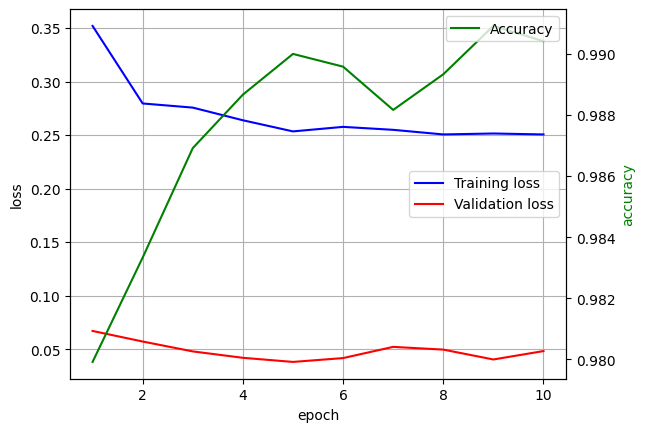

In [9]:
# Display the metrics evolution
fig1, ax1 = plt.subplots()
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.plot(epochs, train_losses, color='b', label='Training loss')
ax1.plot(epochs, validation_losses, color='r', label='Validation loss')
ax1.grid(True)
ax1.legend(loc='right')
ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
ax2.set_ylabel('accuracy', color='g')
ax2.plot(epochs, accuracies, color='g', label='Accuracy')
ax2.legend(loc='upper right')
plt.show()

In [10]:
# Test
mnist_test_dataset = torchvision.datasets.MNIST("./", train=False, download=True, transform=transform)

In [34]:
sample_test_tsr, class_ndx = mnist_test_dataset[1000]
sample_output_tsr = champion_neural_net(sample_test_tsr.unsqueeze(0).to('cpu'))
print(f"sample_output_tsr = \n{sample_output_tsr}")
predicted_class = torch.argmax(sample_output_tsr, dim=1).item()
print(f"predicted_class = {predicted_class}; True class = {class_ndx}")

sample_output_tsr = 
tensor([[-15.3713, -13.5392, -16.5941,  -9.2849,  -4.5390, -10.8496, -26.4739,
          -4.1507,  -9.7473,  11.4806]], grad_fn=<AddmmBackward0>)
predicted_class = 9; True class = 9


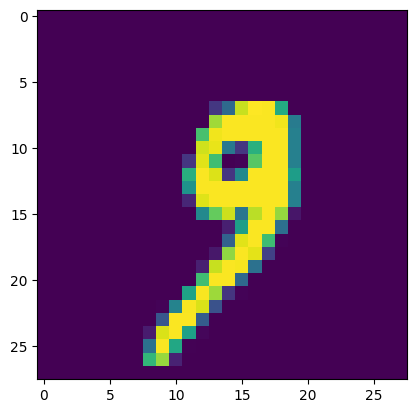

In [35]:
sample_test_arr = sample_test_tsr.numpy()
plt.imshow(sample_test_arr.squeeze(0))